In [1]:
%matplotlib inline
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import time
#from IPython.display import display

## Part1: basically do a repeat of the beginner tutorial

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# in the training set we have 55,000 examples, 784 pixels (28x28)
# and 10 kinds of labels (0 through 9) using "one-hot" encoding
train_count, px_count = mnist.train.images.shape
_, label_count = mnist.train.labels.shape
test_count, _ = mnist.test.images.shape
validation_count, _ = mnist.validation.images.shape
img_width_height = np.int32(np.sqrt(px_count))

print('training set size = ', train_count)
print('test set size = ', test_count)
print('validation set size = ', validation_count)
print('image pixels = ', px_count)
print('width/height = ', img_width_height)
print('label count = ', label_count)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

training set size =  55000
test set size =  10000
validation set size =  5000
image pixels =  784
width/height =  28
label count =  10
(55000, 784)
(55000, 10)


the label is 4


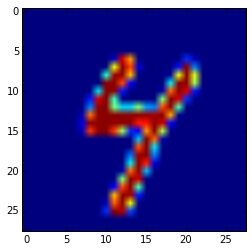

In [4]:
# let's look at an example
which_sample = 33
label = mnist.train.labels[which_sample, :].nonzero()[0][0]
print('the label is', label)
plt.imshow(np.reshape(
    mnist.train.images[which_sample, :],
    (img_width_height, img_width_height)))

In [5]:
sess = tf.InteractiveSession()

# we need placeholders for the images and for the image labels
x = tf.placeholder("float", shape=[None, px_count])
y_ = tf.placeholder("float", shape=[None, label_count])

# we need variables for the weights and biases
W = tf.Variable(tf.zeros([px_count, label_count]))
b = tf.Variable(tf.zeros([label_count]))

sess.run(tf.initialize_all_variables())

In [6]:
# use softmax to predict y
y = tf.nn.softmax(tf.matmul(x, W) + b)

# now optimize to reduce cross entropy. we'll do 1000 iterations
# of 50 sample batches
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
for i in range(1000):
  batch = mnist.train.next_batch(50)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

In [7]:
# let's see how we did in training the model
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print(accuracy.eval(feed_dict={
            x: mnist.test.images,
            y_: mnist.test.labels}))

0.9092


## Part 2: build a multilayer ConvNN

In [8]:
def weight_variable(shape):
    # we will initialize our weights with some random noise
    # for symetry breaking and to prevent 0 gradients
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # since we're using ReLU neurons we should init with a
    # slight positive value to avoid "dead neurons"
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In this tutorial we will only use the "vanilla" values for things like stride size (one) and padding (so that input size == output size). Pooling is plain old max pooling over 2x2 blocks:

In [9]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(
        x,
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME',
    )

### first convolutional layer

In [10]:
# compute 32 features for each 5x5 patch
W_conv1 = weight_variable([
    5,  # 1st patch dimension
    5,  # 2nd patch dimension
    1,  # num of input channels
    32, # num of output channels
])

# attach bias to each output channel
b_conv1 = bias_variable([32])

# reshape x as 28x28x1 images (where 1 is num channels)
x_image = tf.reshape(x, [-1, img_width_height, img_width_height, 1])

# perform convolution and pooling
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### second convolutional layer

In [11]:
# The second layer will have 64 features for each 5x5 patch.
W_conv2 = weight_variable([
    5,  # 1st patch dimension
    5,  # 2nd patch dimension
    32, # num input channels
    64, # num output channels
])

# attach bias to each output channel
b_conv2 = bias_variable([64])

# perform convolution and pooling
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### densely connected layer

In [12]:
# image size has been reduced to 7x7. we now add a fully connected
# layer with 1024 neurons to allow processing on the entire image
# We reshape the tensor from the pooling layer into a batch of
# vectors, multiply by a weight matrix, add a bias, and apply a ReLU.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# we'll perform dropout to reduce the risk of overfitting
# we will need to turn this off during testing
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### readout layer

In [13]:
# we add a softmax layer for activation just like with
# the basic examples
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

### training and evaluation

In [14]:
# we replace gradient descent with ADAM optimizer. The objective is
# still to reduce cross entropy
cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.arg_max(y_conv, 1), tf.arg_max(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.initialize_all_variables())
train_start_time = time.time()
last_time = train_start_time

for i in range(20000):
    #batch = mnist.train.next_batch(50)
    batch = mnist.train.next_batch(100)
    if i % 100 == 0:
        curr_time = time.time()
        time_diff = curr_time - last_time
        last_time = curr_time
        
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0],
            y_: batch[1],
            keep_prob: 1.0, # turn off dropout
        })
        print("{:.2f} sec: step {}, training accuracy {}".format(time_diff, i, train_accuracy))
    train_step.run(feed_dict={
        x: batch[0],
        y_: batch[1],
        keep_prob: 0.5, # turn on dropout
    })

print("completed 20000 iterations in {} sec".format(time.time() - train_start_time))

0.00 sec: step 0, training accuracy 0.119999997318
7.61 sec: step 100, training accuracy 0.889999985695
7.55 sec: step 200, training accuracy 0.949999988079
7.63 sec: step 300, training accuracy 0.879999995232
7.54 sec: step 400, training accuracy 0.949999988079
7.54 sec: step 500, training accuracy 0.949999988079
7.60 sec: step 600, training accuracy 0.97000002861
7.50 sec: step 700, training accuracy 0.959999978542
7.56 sec: step 800, training accuracy 0.920000016689
7.59 sec: step 900, training accuracy 0.959999978542
7.60 sec: step 1000, training accuracy 0.959999978542
7.59 sec: step 1100, training accuracy 0.97000002861
7.60 sec: step 1200, training accuracy 0.980000019073
7.61 sec: step 1300, training accuracy 0.990000009537
7.59 sec: step 1400, training accuracy 0.990000009537
7.63 sec: step 1500, training accuracy 0.959999978542
7.57 sec: step 1600, training accuracy 0.97000002861
7.60 sec: step 1700, training accuracy 0.980000019073
7.53 sec: step 1800, training accuracy 0.97

In [15]:
# apparently my GPU sucks so I can't test the whole set at once.
# That's OK, 7000 samples should be good enough
test_accuracy = accuracy.eval(feed_dict={
    x: mnist.test.images[:7000],
    y_: mnist.test.labels[:7000],
    keep_prob: 1.0, # turn off dropout
})

# test_accuracy = accuracy.eval(feed_dict={
#     x: mnist.test.images,
#     y_: mnist.test.labels,
#     keep_prob: 1.0, # turn off dropout
# })

print('test accuracy: {}'.format(test_accuracy))

test accuracy: 0.991571426392
